In [1]:
from digipat.data.datasets.examples.bcss import BCSS_OOD_Dataset
from digipat.data.augmentations import *

data = BCSS_OOD_Dataset()
aug = SampledOODAugmentation(DarkSpotsAugmentation(), 0.5)
img, mask, meta = aug(torch.ones(3, 300, 300), torch.ones((300, 300)))
meta


DistributionSampleType.IN_DISTRIBUTION_DATA - {}

In [3]:
from digipat.data.metadata import *

test = init_sample_metadata()
test.type= DistributionSampleType.IN_DISTRIBUTION_DATA
test["type"] = DistributionSampleType.DATASET_OOD_DATA
test.data = {"lko": 3, "type": 50}
test.type

<DistributionSampleType.DATASET_OOD_DATA: 4>

  0%|          | 0/953 [00:00<?, ?it/s]C:\Users\jstieber\AppData\Local\conda\conda\envs\ssl4uc\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|          | 9/953 [00:26<46:37,  2.96s/it]  


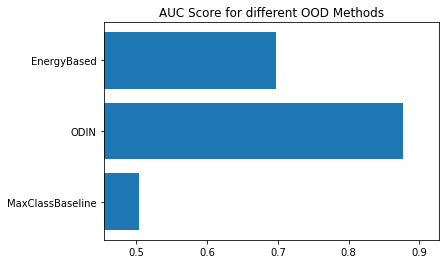

In [1]:
from digipat.ood.strategy import AugmentationStrategy
from digipat.data.datasets.examples.bcss import BCSS_OOD_Dataset
from digipat.data.augmentations import *
from digipat.ood.methods import ODIN, EnergyBased, MaxClassBaseline, ReAct
from digipat.models.segmantation import SegmentationModel
from digipat.data.metadata import MetadataCommonTypes
from digipat.data.container import MetadataContainer, ContainerRequirements
from digipat.ood.metrics import OODAuRoC, infer_container

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd

strategy = AugmentationStrategy(
    BCSS_OOD_Dataset(),
    SampledOODAugmentation(
        DarkSpotsAugmentation(sample_range={"scale": (0.45, 4.75)}), 0.5
    )
)
net = SegmentationModel().load()
methods = [MaxClassBaseline(), ODIN(), EnergyBased()]
i = 0

metrics = [OODAuRoC()]
container = infer_container(metrics)

for img, mask, meta in tqdm.tqdm(strategy.get_dataloader(batch_size=16, num_workers=8)):

    for index, m in enumerate(methods):
        scores = m(img, mask, net)
        scores = np.mean(scores, tuple(range(1, scores.ndim)))
        meta.append_to_keyed_dict(
            MetadataCommonTypes.OOD_SCORE.name, f"{index}_{type(m).__name__}", scores
        )

    for c in container:
        c.append({ContainerRequirements.METADATA: meta.batch})
    
    i += 1
    if i >= 10:
        break

for c in container:
    c.process()

for m in metrics:
    m(container, {})
    m.present(as_plot=True)



{<class 'digipat.ood.methods.react.ReAct'>}
{<class 'digipat.ood.methods.react.ReAct'>}
{<class 'digipat.ood.methods.react.ReAct'>, <class 'digipat.ood.methods.baselines.MaxClassBaseline'>}


In [82]:
in_d = t[(t["type"] == DistributionSampleType.IN_DATA)]
t["bin"] = t["OOD_SEVERITY"].apply(lambda x: x.get_bin(10) if not pd.isna(x) else None)
od_d = t[(t["type"] == DistributionSampleType.OOD_DATA)].groupby("bin")
d_col = [col for col in t if col.startswith(f"{MetadataCommonTypes.OOD_SCORE.name}.")]

print(in_d[d_col].to_numpy())
ood_nested_list = in_d[d_col].apply(lambda x: x.values.tolist())
print(ood_nested_list.to_numpy())
bin_keys = od_d[d_col].groups.keys()


[[0.9197341  0.87481076 3.5770774 ]
 [0.9503245  0.83790255 3.6878684 ]
 [0.9822928  0.8533954  3.9591587 ]
 [0.98882526 0.86234236 3.9362376 ]
 [0.95306903 0.8519389  3.764314  ]
 [0.9468551  0.8390707  3.6905763 ]
 [0.956279   0.8458715  3.7462072 ]
 [0.96474147 0.80840814 3.8635209 ]
 [0.985702   0.8316744  3.9903944 ]
 [0.9916996  0.9782658  4.638292  ]
 [0.9856759  0.96871305 4.6253843 ]
 [0.9526029  0.84425575 3.7232168 ]
 [0.96201044 0.8564512  3.766936  ]
 [0.9651472  0.83438396 3.8125253 ]
 [0.9656409  0.81844455 3.8724663 ]
 [0.97090477 0.8584882  3.837467  ]
 [0.98489755 0.9744214  4.6981597 ]
 [0.973785   0.94973314 4.3002763 ]
 [0.9341227  0.86164105 3.6727903 ]
 [0.9496723  0.8252204  3.8744166 ]
 [0.9484939  0.83524525 3.753793  ]
 [0.957631   0.9144408  3.9627771 ]
 [0.9593383  0.9234015  4.1329136 ]
 [0.92717534 0.8249337  3.6365476 ]
 [0.9573004  0.8080998  4.0366807 ]
 [0.9422272  0.82639307 3.8843775 ]
 [0.94095474 0.84542763 3.7125673 ]
 [0.95700765 0.8669939  3.78

In [46]:
import pandas as pd

print(all[0].data)
test = pd.json_normalize([a.data for a in all])
DistributionSampleType.IN_DISTRIBUTION_DATA.name
test

defaultdict(<function dict_default at 0x000001ED31BCC310>, {'type': <DistributionSampleType.AUGMENTATION_OOD_DATA: 3>, 'OOD_SEVERITY': PixelPercentage [0-1]: 0.8070555329322815, 'OOD_SCORE': {'0_MaxClassBaseline': 0.95399994, '1_ODIN': 0.7659604, '2_EnergyBased': 3.6314614}})


,type,OOD_SEVERITY,OOD_SCORE.0_MaxClassBaseline,OOD_SCORE.1_ODIN,OOD_SCORE.2_EnergyBased
0,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.8070555329322815,0.954000,0.765960,3.631461
1,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.955697,0.919083,3.948238
2,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.949582,0.841722,3.643372
3,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.05165555700659752,0.961023,0.837734,3.891705
4,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.04721111059188843,0.950182,0.828156,3.796163
...,...,...,...,...,...
1595,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.08364444226026535,0.946027,0.865525,4.217421
1596,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.957214,0.907939,5.377982
1597,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.4543111026287079,0.951531,0.851290,5.022236
1598,DistributionSampleType.AUGMENTATION_OOD_DATA,PixelPercentage [0-1]: 0.6734222173690796,0.920955,0.753346,4.079607


In [51]:
test[test["type"] == DistributionSampleType.IN_DISTRIBUTION_DATA]
test["bin"] = test["OOD_SEVERITY"].apply(lambda x: x.get_bin(10) if not pd.isna(x) else None)
in_d = test[(test["type"] == DistributionSampleType.IN_DISTRIBUTION_DATA)]
in_d

,type,OOD_SEVERITY,OOD_SCORE.0_MaxClassBaseline,OOD_SCORE.1_ODIN,OOD_SCORE.2_EnergyBased,bin
1,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.955697,0.919083,3.948238,NaN
2,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.949582,0.841722,3.643372,NaN
6,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.975786,0.853905,3.842583,NaN
7,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.980347,0.853312,3.942138,NaN
14,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.952342,0.839062,3.724517,NaN
...,...,...,...,...,...,...
1587,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.921613,0.829729,3.551795,NaN
1588,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.978674,0.875985,4.185493,NaN
1590,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.980023,0.878146,4.149152,NaN
1591,DistributionSampleType.IN_DISTRIBUTION_DATA,NaN,0.974337,0.878608,4.232892,NaN


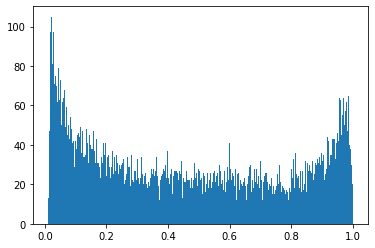

In [6]:
    # print(np.mean(score,tuple(range(1, score.ndim))))
    # all.extend(
    #    [
    #        m["severity"].measurement
    #        for m in meta
    #        if m.type is DistributionSampleType.AUGMENTATION_OOD_DATA
    #    ]
    # )

import numpy as np
plt.hist(all, 500)
plt.show()


In [52]:
data= {"test": 5, "lol": 3}
for key, val in data.items():
            print(key, val)

test 5
lol 3
